In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.table import Table
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import sigma_clipped_stats
from sklearn.cluster import DBSCAN
from scipy.stats import median_abs_deviation
from sklearn.linear_model import RANSACRegressor

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

In [2]:
main = "C:/Users/aurel/Desktop/DUAO Projet/(6) Hebe"

In [3]:
date = "20240531"
filter = "SDSSrp+"

phot_dir = f"{main}/LIGHT/{date}/{filter}/PHOTOMETRY"
# phot_dir2 = f"{main}/LIGHT/{'20240605'}/{filter}/PHOTOMETRY"

files = glob.glob(f"{phot_dir}/*.csv")# + glob.glob(f"{phot_dir2}/*.csv")

### Concatenate photometry tables

In [4]:
RA, DEC = [], []
MJD = []
INS_MAG, APP_MAG = [], []
ERR_MAG = []

for file in files:
    mjd = fits.open(file.replace('_phot.csv', '.fits').replace('PHOTOMETRY', 'REDUCED'))[0].header['MJD-OBS']
    phot_table = ascii.read(file, format='csv')
    MJD += [mjd]*len(phot_table)
    RA += list(phot_table['ra'].data)
    DEC += list(phot_table['dec'].data)
    INS_MAG += list(phot_table['ins_mag'].data)
    APP_MAG += list(phot_table['app_mag'].data)
    ERR_MAG += list(phot_table['ins_err'].data)

RA = np.array(RA)
DEC = np.array(DEC)
MJD = np.array(MJD)
INS_MAG = np.array(INS_MAG)
APP_MAG = np.array(APP_MAG)
ERR_MAG = np.array(ERR_MAG)

### Cluster sources

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


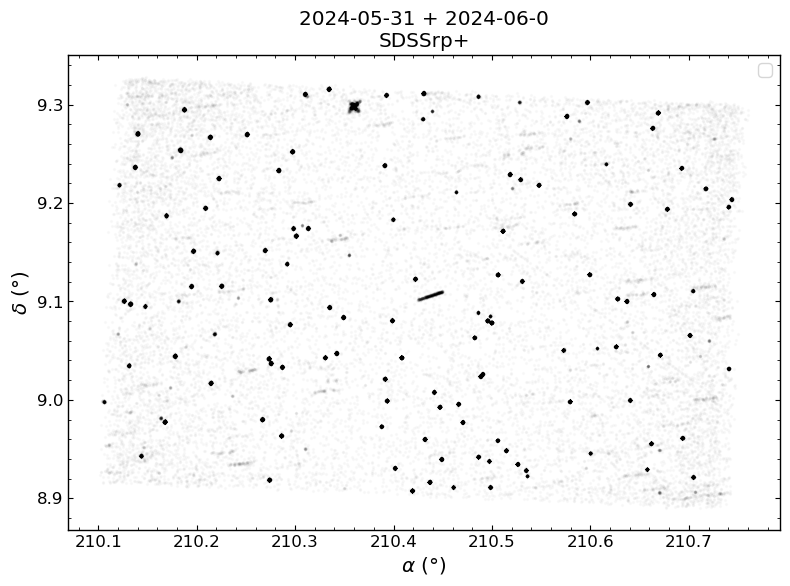

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(RA, DEC, marker='o', s=2, c='k', alpha=0.02, rasterized=True)
# ax.add_patch(Ellipse([210.44, 9.105], 0.06, 0.025, 20, fc='none', ec='r', label='(6) Hebe'))
# ax.add_patch(Ellipse([209.925, 8.863], 0.04, 0.02, 30, fc='none', ec='r'))
ax.set_xlabel(r"$\alpha$ (°)")
ax.set_ylabel(r"$\delta$ (°)")
ax.set_title(f"2024-05-31 + 2024-06-0\n{filter}")
ax.set_aspect('equal', adjustable='box')
ax.legend()
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Full-field_{filter}.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Full-field_{filter}.png", bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

In [6]:
max_sep = 3*u.arcsec
points = np.array([RA, DEC]).T

db = DBSCAN(eps=max_sep.to(u.deg).value, min_samples=5).fit(points)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 208
Estimated number of noise points: 19194


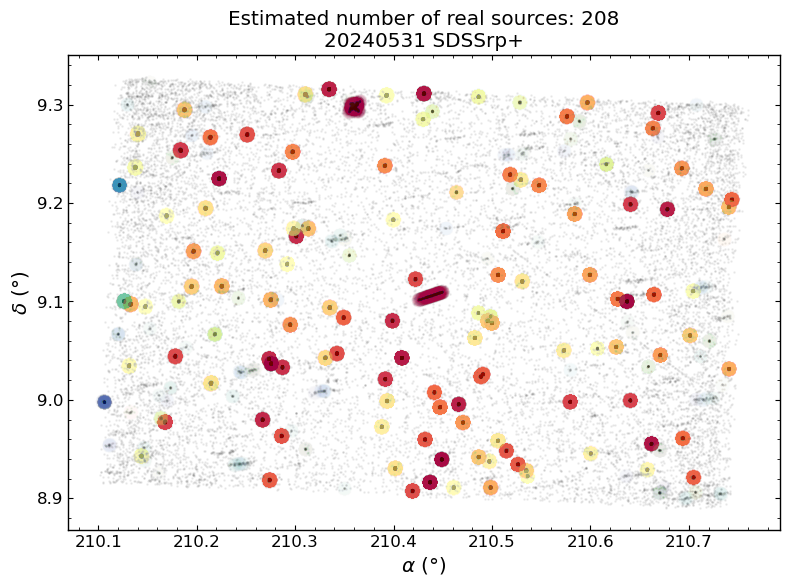

In [7]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, ax = plt.subplots(figsize=(8,8))

for k, col in zip(unique_labels, colors):

    if k!=-1:
        xy = points[labels==k]
        ax.plot(xy[:, 0], xy[:, 1], "o",
            markerfacecolor=tuple(col),
            markeredgecolor="none",
            markersize=10,
            alpha=0.01,
            rasterized=True
    )
        
ax.scatter(RA, DEC, marker='o', s=1, alpha=0.05, c='k', rasterized=True)

ax.set_xlabel(r"$\alpha$ (°)")
ax.set_ylabel(r"$\delta$ (°)")
ax.set_title(f"Estimated number of real sources: {n_clusters_}\n{date} {filter}")
ax.set_aspect('equal', adjustable='box')
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Field_{date}_{filter}.pdf", bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Field_{date}_{filter}.png", bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

### Create time series table

In [8]:
RA_temp, DEC_temp = [], []
MJD_temp = []
INS_MAG_temp, APP_MAG_temp = [], []
ERR_MAG_temp = []
for k in unique_labels:
    if k!=-1:
        idx = np.where(labels==k)[0]
        RA_temp.append(RA[idx])
        DEC_temp.append(DEC[idx])
        MJD_temp.append(MJD[idx])
        INS_MAG_temp.append(INS_MAG[idx])
        APP_MAG_temp.append(APP_MAG[idx])
        ERR_MAG_temp.append(ERR_MAG[idx])

phot_temporal = Table(data=[RA_temp, DEC_temp, MJD_temp, INS_MAG_temp, APP_MAG_temp, ERR_MAG_temp], 
                      names=['ra', 'dec', 'mjd', 'ins_mag', 'app_mag', 'err_mag'])
len(phot_temporal)

208

### Apparent magnitudes

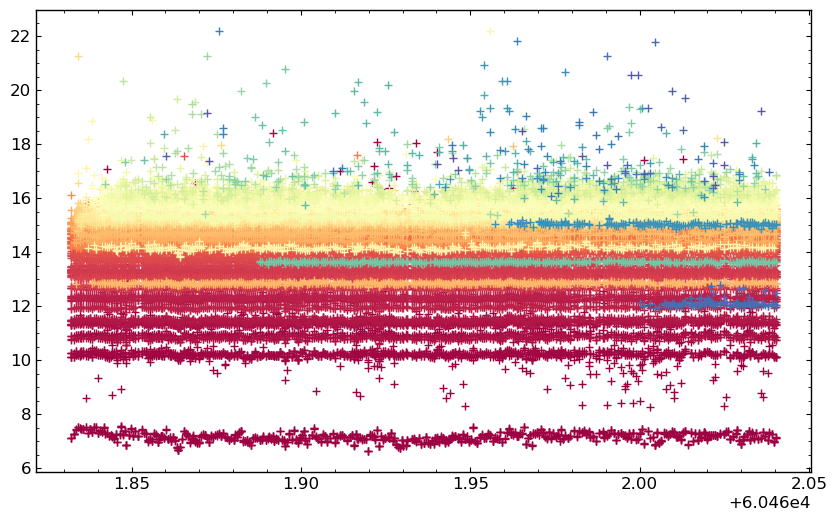

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(len(phot_temporal)):
    ax.plot(phot_temporal[i]['mjd'], phot_temporal[i]['app_mag'], ls='', marker='+', color=tuple(colors[i]))
plt.show()

### Median magnitudes and airmass

In [10]:
ins_mag_med = []
app_mag_med = []
ins_mag_norm = []
for s in phot_temporal:
    ins_med = sigma_clipped_stats(s['ins_mag'], sigma=3.0)[1]
    ins_mag_med.append(ins_med)
    app_med = sigma_clipped_stats(s['app_mag'], sigma=3.0)[1]
    app_mag_med.append(app_med)
    ins_mag_norm.append(s['ins_mag']/ins_med)
phot_temporal['ins_mag_med'] = ins_mag_med
phot_temporal['app_mag_med'] = app_mag_med
phot_temporal['ins_mag_norm'] = ins_mag_norm

In [11]:
ref_mag_min, ref_mag_max = 10, 12
reference_stars = np.where((phot_temporal['app_mag_med']>11)&(phot_temporal['app_mag_med']<14))[0]

airmass = []
AIRMASS = [np.ones_like(s['mjd']) for s in phot_temporal]
for mjd in np.unique(MJD):
    ins_mag = []
    for i in reference_stars: # TODO Change criterion with mag
        s = phot_temporal[i]
        if mjd in s['mjd']:
            ins_mag.append(np.median(s['ins_mag_norm'][s['mjd']==mjd]))
    airmass_val = 1/sigma_clipped_stats(ins_mag, sigma=3.0)[1]
    airmass.append(airmass_val)
    for i, s in enumerate(phot_temporal):
        AIRMASS[i][s['mjd']==mjd] = airmass_val
phot_temporal['airmass'] = AIRMASS

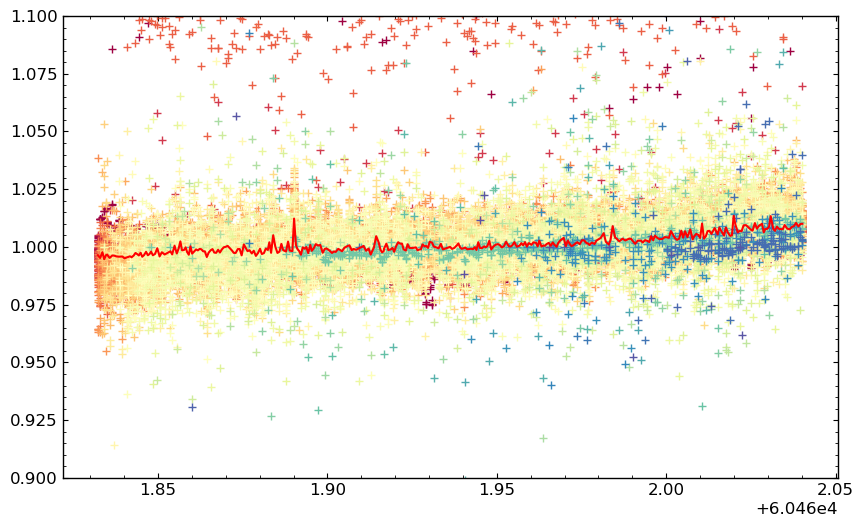

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(len(phot_temporal)):
    ax.plot(phot_temporal[i]['mjd'], 1/phot_temporal[i]['ins_mag_norm'], ls='', marker='+', color=tuple(colors[i]))
ax.plot(np.unique(MJD), airmass, color='red')
ax.set_ylim(0.9, 1.1)
plt.show()

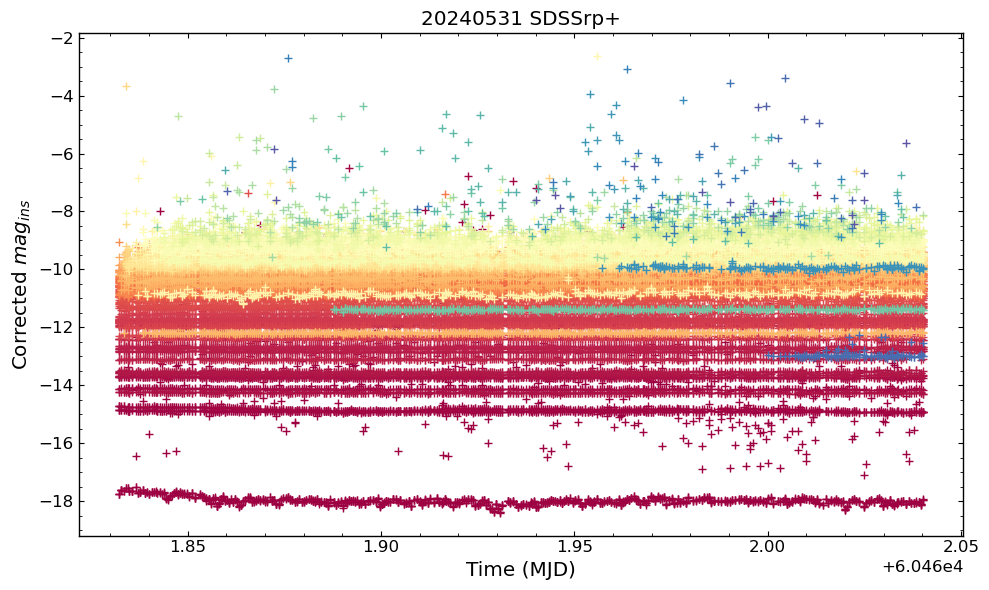

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(len(phot_temporal)):
    s = phot_temporal[i]
    ax.plot(s['mjd'], s['ins_mag']*s['airmass'], ls='', marker='+', color=tuple(colors[i]), rasterized=True)
ax.set_ylabel(r"Corrected $mag_{ins}$")
ax.set_xlabel("Time (MJD)")
ax.set_title(f"{date} {filter}")
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Full_mag-ins_{date}_{filter}.pdf", bbox_inches=0, pad_inches=0)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Full_mag-ins_{date}_{filter}.png", bbox_inches=0, pad_inches=0, dpi=200)
# ax.set_ylim(-15,-14)
plt.show()

### Zero point comparison

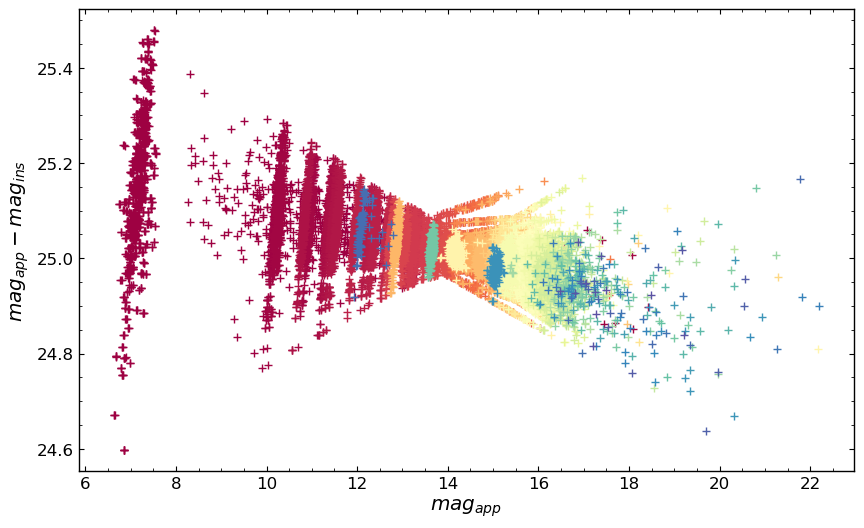

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(len(phot_temporal)):
    s = phot_temporal[i]
    ax.plot(s['app_mag'], s['app_mag'] - s['ins_mag']*s['airmass'], ls='', marker='+', color=tuple(colors[i]))
ax.set_xlabel(r"$mag_{app}$")
ax.set_ylabel(r"$mag_{app} - mag_{ins}$")
# ax.set_aspect('equal')
plt.show()

### Proper motion

In [15]:
P_RA, P_DEC = [], []
mjd_mid = np.unique(MJD)[len(np.unique(MJD))//2]
for i in range(len(phot_temporal)):
    s = phot_temporal[i]
    X = s['mjd'].reshape(-1, 1)
    # PM RA
    Y = s['ra'].reshape(-1, 1)
    MAD = median_abs_deviation(X-Y, axis=None)
    ransac = RANSACRegressor(residual_threshold=3*MAD)
    ransac.fit(X, Y)
    dra_dt = ransac.estimator_.coef_[0][0]*(u.deg/u.d).to(u.arcsec/u.h)
    P_RA.append(dra_dt)
    # PM Dec
    Y = s['dec'].reshape(-1, 1)
    MAD = median_abs_deviation(X-Y, axis=None)
    ransac = RANSACRegressor(residual_threshold=3*MAD)
    ransac.fit(X, Y)
    ddec_dt = ransac.estimator_.coef_[0][0]*(u.deg/u.d).to(u.arcsec/u.h)
    P_DEC.append(ddec_dt)
phot_temporal['p_ra'] = P_RA
phot_temporal['p_dec'] = P_DEC

### Fastest moving target

In [18]:
long_time = [len(phot_temporal['mjd'][i])>50 for i in range(len(phot_temporal))]
abs_pm = np.linalg.norm(np.array([phot_temporal['p_ra'], phot_temporal['p_dec']]).T, axis=1)
target = np.ma.argmax(np.ma.array(abs_pm, mask=np.logical_not(long_time)))
reference_stars = np.delete(reference_stars, np.where(reference_stars==target))

In [19]:
print(f"dα = {phot_temporal[target]['p_ra']:.2f}\"/s")
print(f"dδ = {phot_temporal[target]['p_dec']:.2f}\"/s")

dα = -18.16"/s
dδ = -6.03"/s


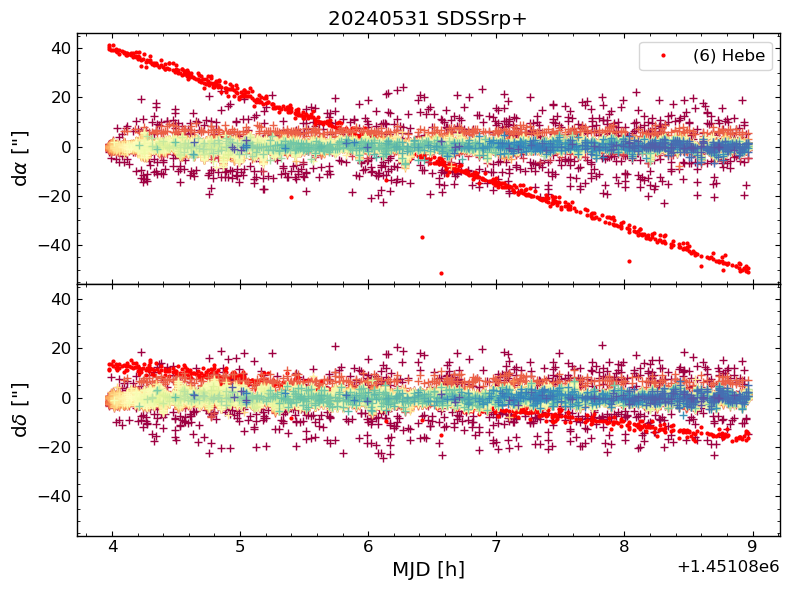

In [20]:
fig, axs = plt.subplots(2,1,figsize=(8,6), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})
for i in range(len(phot_temporal)):
    s = phot_temporal[i]
    delta_ra = (s['ra'] - np.nanmedian(s['ra']))*3600
    delta_dec = (s['dec'] - np.nanmedian(s['dec']))*3600
    if i==target:
        axs[0].plot(s['mjd']*24, delta_ra, ls='', marker='o', color='red', ms=2, label='(6) Hebe')
        axs[1].plot(s['mjd']*24, delta_dec, ls='', marker='o', color='red', ms=2, label='(6) Hebe')
    else:
        axs[0].plot(s['mjd']*24, delta_ra, ls='', marker='+', color=tuple(colors[i]), rasterized=True)
        axs[1].plot(s['mjd']*24, delta_dec, ls='', marker='+', color=tuple(colors[i]), rasterized=True)
axs[0].set_ylabel(r'd$\alpha$ ["]')
axs[1].set_ylabel(r'd$\delta$ ["]')
axs[1].set_xlabel('MJD [h]')
axs[0].legend(loc='upper right')
axs[0].set_title(f"{date} {filter}")
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/PM_{date}_{filter}.pdf", bbox_inches=0, pad_inches=0)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/PM_{date}_{filter}.png", bbox_inches=0, pad_inches=0, dpi=200)
plt.show()

### Asteroid light curve

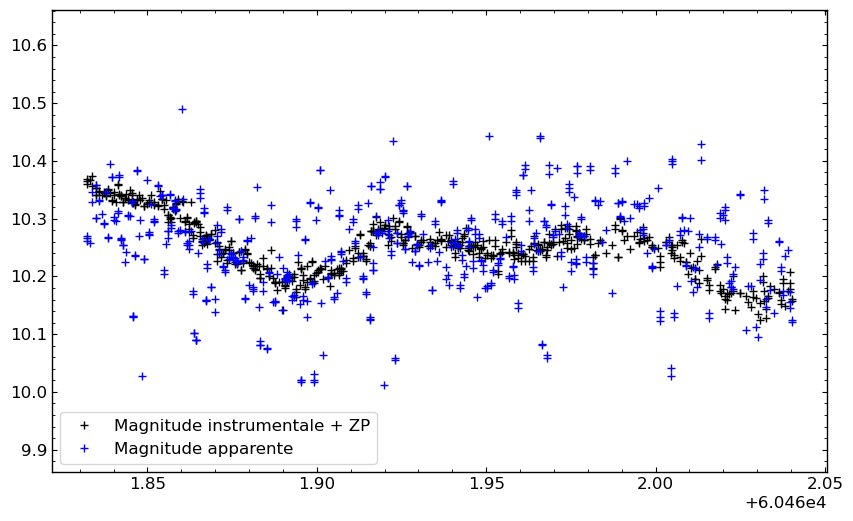

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
s = phot_temporal[target]
ZP = np.nanmedian(s['app_mag'] - s['ins_mag']*s['airmass'])
ax.plot(s['mjd'], s['ins_mag']*s['airmass'] + ZP, ls='', marker='+', color='k', label='Magnitude instrumentale + ZP')
ax.plot(s['mjd'], s['app_mag'], ls='', marker='+', color='b', label='Magnitude apparente')
ax.set_ylim(s['app_mag_med']-0.4,s['app_mag_med']+0.4)
ax.legend()
plt.show()

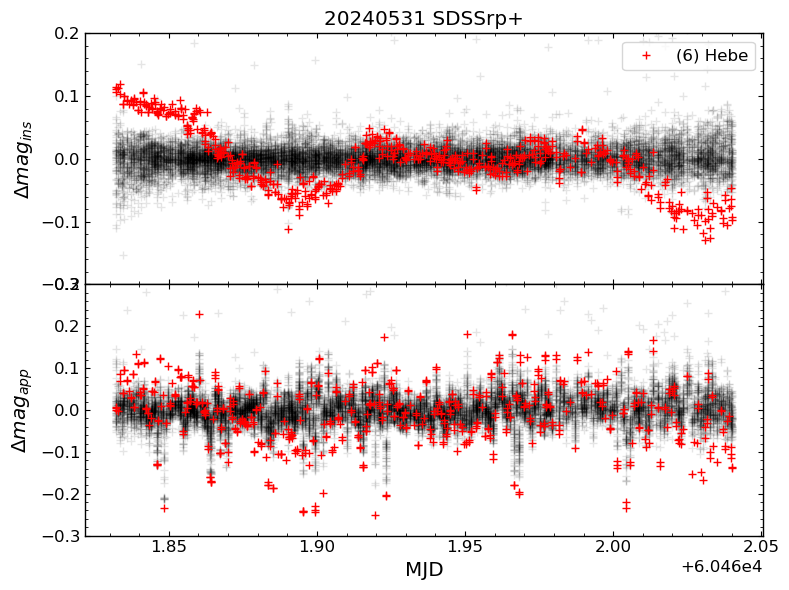

In [22]:
fig, axs = plt.subplots(2,1,figsize=(8,6), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0})

for i in reference_stars:
    s = phot_temporal[i]
    axs[0].plot(s['mjd'], s['ins_mag']*s['airmass'] - np.nanmedian(s['ins_mag']*s['airmass']), ls='', marker='+', color='k', alpha=0.1, rasterized=True)
    axs[1].plot(s['mjd'], s['app_mag'] - np.nanmedian(s['app_mag']), ls='', marker='+', color='k', alpha=0.1, rasterized=True)

s = phot_temporal[target]
axs[0].plot(s['mjd'], s['ins_mag']*s['airmass'] - np.nanmedian(s['ins_mag']*s['airmass']), ls='', marker='+', color='red', label='(6) Hebe')
axs[1].plot(s['mjd'], s['app_mag'] - np.nanmedian(s['app_mag']), ls='', marker='+', color='red', label='(6) Hebe')

axs[0].set_ylabel('$\Delta mag_{ins}$')
axs[1].set_ylabel('$\Delta mag_{app}$')
axs[0].set_ylim(-0.2,0.2)
axs[1].set_ylim(-0.3,0.3)
axs[1].set_xlabel('MJD')
axs[0].set_title(f"{date} {filter}")
axs[0].legend(loc='upper right')
fig.tight_layout()
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Delta-mag_{date}_{filter}.pdf", bbox_inches=0, pad_inches=0)
# fig.savefig(f"C:/Users/aurel/VirtualBox VMs/DUAO/Partage/Rapport/images/projet/Delta-mag_{date}_{filter}.png", bbox_inches=0, pad_inches=0, dpi=200)
plt.show()

In [23]:
REL_FLUX = []
for i in range(len(phot_temporal)):
    s = phot_temporal[i]
    flux = 10**(-0.4*s['ins_mag']*s['airmass'])
    rel_flux = flux/np.nanmedian(flux)
    REL_FLUX.append(rel_flux)
phot_temporal['rel_flux'] = REL_FLUX

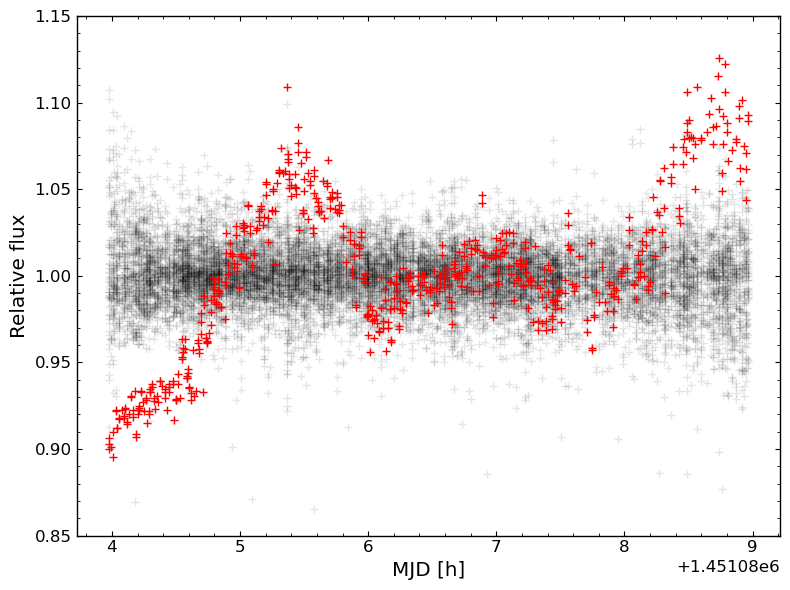

In [24]:
fig, ax = plt.subplots(1,1,figsize=(8,6), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0})

for i in reference_stars:
    s = phot_temporal[i]
    ax.plot(s['mjd']*24, s['rel_flux'], ls='', marker='+', color='k', alpha=0.1)

s = phot_temporal[target]
ax.plot(s['mjd']*24, s['rel_flux'], ls='', marker='+', color='red')

ax.set_ylabel('Relative flux')
ax.set_ylim(0.85,1.15)
ax.set_xlabel('MJD [h]')
fig.tight_layout()
plt.show()

### Save temporal photometry

In [482]:
ascii.write(phot_temporal, f"{main}/tempo-photo_{date}_{filter}.ecsv", format='ecsv', overwrite=True)